## 12-31-2025

# Module 2: Feature Extraction

**Purpose:**
Extract multi-modal features from BAM files for classification.

**Features Extracted:**
1. **Fragment size features** - distributions, summary stats, size bins
2. **Position features** - start/end positions, coverage across chr21
3. **End motif features** - 4-mer frequencies from fragment ends
4. **Methylation features** - CpG methylation from XM tags

**Inputs:**
- `data/processed/sample_manifest.csv` (from Module 0)
- BAM files

**Outputs:**
- `data/processed/all_features.csv` (~370+ features × 22 samples)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import Module 2 functions
from src.feature_extraction import (
    extract_fragment_features,
    extract_position_features,
    extract_motif_features,
    extract_methylation_features,
    extract_all_features_from_bam,
    run_module_2
)

# Import config
from src.config import (
    SAMPLE_MANIFEST,
    ALL_FEATURES,
    KMER_SIZE,
    FRAGMENT_SIZE_BINS
)

## Option 1: Quick Run - Execute Complete Module 2

Extract all features from all 22 samples at once:

In [3]:
# Run complete Module 2 pipeline
features_df = run_module_2()


MODULE 2: Feature Extraction

Loading sample manifest from: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/sample_manifest.csv
✓ Loaded manifest: 22 samples

Extracting features from all samples...


Processing samples: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:42<00:00,  1.94s/it]


✓ Feature extraction complete
  Samples: 22
  Total features: 391

✓ Saved all features to: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/all_features.csv

Feature breakdown:
  Fragment size features: 17
  Position features: 105
  Motif features: 259
  Methylation features: 10
  Total: 391

MODULE 2 COMPLETE



## Examine Feature Matrix

Check extracted features:

In [4]:
# Display shape
print(f"Feature matrix shape: {features_df.shape}")
print(f"  Samples: {features_df.shape[0]}")
print(f"  Total columns: {features_df.shape[1]}")
print(f"  Features (excluding metadata): {features_df.shape[1] - 4}")

# Show columns
print(f"\nColumn names (first 20):")
print(list(features_df.columns[:20]))

# Display first few rows
features_df.head()

Feature matrix shape: (22, 395)
  Samples: 22
  Total columns: 395
  Features (excluding metadata): 391

Column names (first 20):
['sample_id', 'disease_status', 'batch', 'age', 'n_fragments', 'frag_mean', 'frag_median', 'frag_std', 'frag_min', 'frag_max', 'frag_q25', 'frag_q50', 'frag_q75', 'frag_iqr', 'frag_skewness', 'frag_kurtosis', 'frag_pct_very_short', 'frag_pct_short', 'frag_pct_nucleosomal', 'frag_pct_dinucleosomal']


,sample_id,disease_status,batch,age,n_fragments,frag_mean,frag_median,frag_std,frag_min,frag_max,...,meth_reads_with_xm,meth_total_cpg_sites,meth_total_chg_sites,meth_total_chh_sites,meth_cpg_rate,meth_chg_rate,meth_chh_rate,meth_mean_per_read,meth_std_per_read,meth_median_per_read
0,SRR13404367,als,discovery,61,60905,174.460340,162.0,54.978226,51,983,...,121810,88035,400351,1374977,0.822502,0.004544,0.004823,0.814763,0.365339,1.0
1,SRR13404368,als,discovery,57,61810,171.344944,157.0,56.706606,52,952,...,123620,86077,385642,1333369,0.829374,0.005041,0.004966,0.824033,0.358773,1.0
2,SRR13404369,als,discovery,85,61328,164.142105,154.0,52.104917,50,982,...,122656,88269,393327,1334065,0.824876,0.004513,0.004792,0.816314,0.364222,1.0
3,SRR13404370,als,discovery,63,59270,205.717193,169.0,98.206821,50,980,...,118540,93376,405122,1385940,0.811343,0.003604,0.003673,0.817158,0.362380,1.0
4,SRR13404371,ctrl,discovery,60,59786,172.871625,161.0,53.156348,52,931,...,119572,83031,378893,1330640,0.834544,0.003188,0.003317,0.823470,0.359505,1.0


In [5]:
# Count features by type
feature_types = {
    'Fragment size': [c for c in features_df.columns if c.startswith('frag_') or c == 'n_fragments'],
    'Position': [c for c in features_df.columns if c.startswith('pos_') or c == 'n_positions'],
    'Motif': [c for c in features_df.columns if c.startswith('motif_') or c == 'n_motifs'],
    'Methylation': [c for c in features_df.columns if c.startswith('meth_')],
    'Metadata': ['sample_id', 'disease_status', 'batch', 'age']
}

print("Feature Breakdown:")
print("=" * 50)
for feat_type, cols in feature_types.items():
    print(f"{feat_type:20s}: {len(cols):4d} features")

print(f"\n{'Total':20s}: {sum(len(cols) for cols in feature_types.values()):4d} columns")

Feature Breakdown:
Fragment size       :   17 features
Position            :  105 features
Motif               :  259 features
Methylation         :   10 features
Metadata            :    4 features

Total               :  395 columns


## Check for Missing Data

Make sure feature extraction worked for all samples:

In [6]:
# Check for NaN values
nan_counts = features_df.isna().sum()
features_with_nans = nan_counts[nan_counts > 0]

print(f"Features with missing values: {len(features_with_nans)}")

if len(features_with_nans) > 0:
    print("\nTop 10 features with most NaNs:")
    print(features_with_nans.sort_values(ascending=False).head(10))
else:
    print("\n✓ No missing values in any features!")

# Check samples with most NaNs
sample_nan_counts = features_df.isna().sum(axis=1)
print(f"\nSamples with missing values:")
print(features_df[['sample_id', 'disease_status', 'batch']].assign(
    n_nans=sample_nan_counts
).sort_values('n_nans', ascending=False).head(10))

Features with missing values: 0

✓ No missing values in any features!

Samples with missing values:
     sample_id disease_status       batch  n_nans
0  SRR13404367            als   discovery       0
1  SRR13404368            als   discovery       0
2  SRR13404369            als   discovery       0
3  SRR13404370            als   discovery       0
4  SRR13404371           ctrl   discovery       0
5  SRR13404372           ctrl   discovery       0
6  SRR13404373           ctrl   discovery       0
7  SRR13404374           ctrl   discovery       0
8  SRR13404375            als  validation       0
9  SRR13404376            als  validation       0


## Summary Statistics by Feature Type

Look at the extracted features:

In [7]:
# Fragment size features
frag_cols = [c for c in features_df.columns if c.startswith('frag_')]

print("Fragment Size Features Summary:")
print("=" * 70)
print(features_df[frag_cols].describe().T)

Fragment Size Features Summary:
                        count        mean        std         min         25%  \
frag_mean                22.0  172.430781  11.021828  161.287850  165.994773   
frag_median              22.0  159.227273   3.963306  154.000000  156.250000   
frag_std                 22.0   59.595144  12.356086   47.280190   52.467341   
frag_min                 22.0   50.363636   0.657952   50.000000   50.000000   
frag_max                 22.0  921.318182  61.441716  754.000000  889.750000   
frag_q25                 22.0  143.681818   4.156307  138.000000  141.000000   
frag_q50                 22.0  159.227273   3.963306  154.000000  156.250000   
frag_q75                 22.0  178.454545  12.527027  167.000000  173.000000   
frag_iqr                 22.0   34.772727   9.821899   26.000000   30.000000   
frag_skewness            22.0    2.907584   0.338933    2.347302    2.712248   
frag_kurtosis            22.0   13.524932   3.855521    7.011268   11.291453   
frag_pct

In [8]:
# Methylation features
meth_cols = [c for c in features_df.columns if c.startswith('meth_')]

print("\nMethylation Features Summary:")
print("=" * 70)
print(features_df[meth_cols].describe().T)


Methylation Features Summary:
                      count          mean           std           min  \
meth_reads_with_xm     22.0  1.207495e+05   1507.352385  1.185400e+05   
meth_total_cpg_sites   22.0  8.578073e+04   4471.635273  7.296100e+04   
meth_total_chg_sites   22.0  3.877368e+05  15249.250048  3.403130e+05   
meth_total_chh_sites   22.0  1.339264e+06  38687.586441  1.232541e+06   
meth_cpg_rate          22.0  8.191141e-01      0.009306  8.045176e-01   
meth_chg_rate          22.0  4.680216e-03      0.004331  2.588584e-03   
meth_chh_rate          22.0  4.861759e-03      0.004454  2.504430e-03   
meth_mean_per_read     22.0  8.114459e-01      0.011475  7.930010e-01   
meth_std_per_read      22.0  3.681441e-01      0.008558  3.561282e-01   
meth_median_per_read   22.0  1.000000e+00      0.000000  1.000000e+00   

                               25%           50%           75%           max  
meth_reads_with_xm    1.194340e+05  1.211090e+05  1.217945e+05  1.236200e+05  
meth_to


Top 20 Most Common End Motifs (mean frequency %):
motif_TTTT    5.041110
motif_AAAA    4.411187
motif_ATTT    2.816980
motif_TTTA    2.807520
motif_AAAT    2.771214
motif_TAAA    2.580527
motif_TATT    2.508098
motif_AATA    2.348537
motif_TTAT    2.347540
motif_AATT    2.201321
motif_ATAA    2.162470
motif_ATAT    2.058560
motif_TTAA    2.034923
motif_TATA    1.969475
motif_ATTA    1.759029
motif_TAAT    1.745477
motif_AAAC    1.256994
motif_GTTT    1.222557
motif_TTTG    1.030789
motif_CAAA    0.967891
dtype: float64


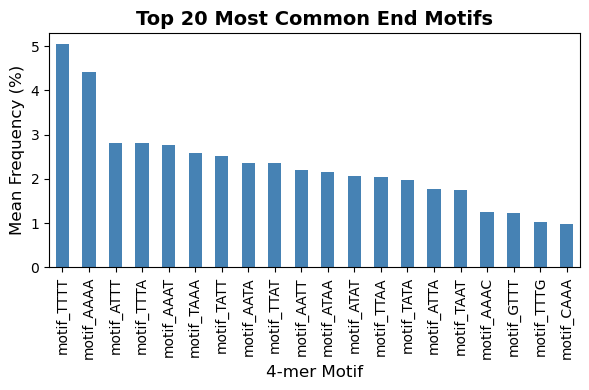

In [14]:
# Top 10 most common motifs
motif_freq_cols = [c for c in features_df.columns if c.startswith('motif_') and len(c) == 10]  # motif_XXXX

# Calculate mean frequency across all samples
motif_means = features_df[motif_freq_cols].mean().sort_values(ascending=False)

print("\nTop 20 Most Common End Motifs (mean frequency %):")
print("=" * 70)
print(motif_means.head(20))

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
motif_means.head(20).plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Top 20 Most Common End Motifs', fontsize=14, fontweight='bold')
ax.set_xlabel('4-mer Motif', fontsize=12)
ax.set_ylabel('Mean Frequency (%)', fontsize=12)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

## Option 2: Step-by-Step (Optional)

If you want to see feature extraction on a single sample:

In [16]:
# Load manifest
manifest = pd.read_csv(SAMPLE_MANIFEST)

# Pick first sample
first_sample = manifest.iloc[0]
sample_id = first_sample['sample_id']
bam_path = first_sample['bam_path']

print(f"Extracting features from: {sample_id}")
print(f"BAM file: {Path(bam_path).name}")
print("=" * 70)

# Extract each feature type separately
print("\n1. Fragment size features...")
frag_feats = extract_fragment_features(bam_path, sample_id)
print(f"   Extracted {len(frag_feats)} fragment features")
print(f"   Example: mean fragment size = {frag_feats.get('frag_mean', 'N/A'):.1f} bp")

print("\n2. Position features...")
pos_feats = extract_position_features(bam_path, sample_id)
print(f"   Extracted {len(pos_feats)} position features")

print("\n3. Motif features...")
motif_feats = extract_motif_features(bam_path, sample_id)
print(f"   Extracted {len(motif_feats)} motif features")
print(f"   Example: motif diversity = {motif_feats.get('motif_diversity', 'N/A'):.2f}")

print("\n4. Methylation features...")
meth_feats = extract_methylation_features(bam_path, sample_id)
print(f"   Extracted {len(meth_feats)} methylation features")
print(f"   Example: CpG methylation = {meth_feats.get('meth_cpg_rate', 'N/A'):.4f}")

# Combine
all_feats = {**frag_feats, **pos_feats, **motif_feats, **meth_feats}
print(f"\n✓ Total features for {sample_id}: {len(all_feats)}")

Extracting features from: SRR13404367
BAM file: SRR13404367.deduplicated.sorted_ds10mill_chr21.bam

1. Fragment size features...
   Extracted 18 fragment features
   Example: mean fragment size = 174.5 bp

2. Position features...
   Extracted 106 position features

3. Motif features...
   Extracted 260 motif features
   Example: motif diversity = 6.75

4. Methylation features...
   Extracted 11 methylation features
   Example: CpG methylation = 0.8225

✓ Total features for SRR13404367: 392


## Compare ALS vs Control

Quick look at features between groups:

In [17]:
from scipy.stats import mannwhitneyu

# Select some key features to compare
key_features = [
    'frag_mean', 'frag_median', 'frag_std',
    'frag_pct_nucleosomal', 'frag_pct_short',
    'meth_cpg_rate', 'meth_std_per_read',
    'motif_diversity', 'motif_gc_content'
]

# Compare ALS vs Control
comparisons = []

for feature in key_features:
    if feature in features_df.columns:
        als_vals = features_df[features_df['disease_status'] == 'als'][feature].dropna()
        ctrl_vals = features_df[features_df['disease_status'] == 'ctrl'][feature].dropna()
        
        if len(als_vals) > 0 and len(ctrl_vals) > 0:
            stat, p_value = mannwhitneyu(als_vals, ctrl_vals, alternative='two-sided')
            
            comparisons.append({
                'feature': feature,
                'als_mean': als_vals.mean(),
                'ctrl_mean': ctrl_vals.mean(),
                'difference': als_vals.mean() - ctrl_vals.mean(),
                'p_value': p_value,
                'significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
            })

comp_df = pd.DataFrame(comparisons)
print("ALS vs Control - Key Feature Comparison:")
print("=" * 80)
print(comp_df.to_string(index=False))

print("\n* p<0.05, ** p<0.01, *** p<0.001")

ALS vs Control - Key Feature Comparison:
             feature   als_mean  ctrl_mean  difference  p_value significant
           frag_mean 169.774515 175.618300   -5.843785 0.032114           *
         frag_median 158.166667 160.500000   -2.333333 0.089454            
            frag_std  56.327267  63.516598   -7.189331 0.009199          **
frag_pct_nucleosomal  52.696698  53.311554   -0.614857 0.921212            
      frag_pct_short  31.897832  28.682514    3.215318 0.198516            
       meth_cpg_rate   0.817840   0.820643   -0.002803 0.620928            
   meth_std_per_read   0.369396   0.366642    0.002753 0.531045            
     motif_diversity   6.765923   6.755553    0.010370 0.448279            
    motif_gc_content  22.150106  21.741923    0.408183 0.080575            

* p<0.05, ** p<0.01, *** p<0.001


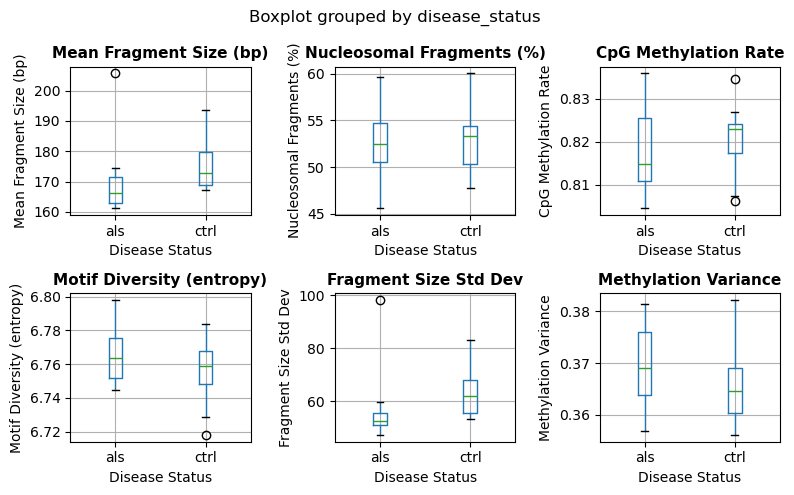

In [20]:
# Plot key features
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
fig.suptitle('Key Features: ALS vs Control', fontsize=16, fontweight='bold')

plot_features = [
    ('frag_mean', 'Mean Fragment Size (bp)'),
    ('frag_pct_nucleosomal', 'Nucleosomal Fragments (%)'),
    ('meth_cpg_rate', 'CpG Methylation Rate'),
    ('motif_diversity', 'Motif Diversity (entropy)'),
    ('frag_std', 'Fragment Size Std Dev'),
    ('meth_std_per_read', 'Methylation Variance')
]

for idx, (feature, label) in enumerate(plot_features):
    ax = axes[idx // 3, idx % 3]
    
    if feature in features_df.columns:
        features_df.boxplot(column=feature, by='disease_status', ax=ax)
        ax.set_title(label, fontsize=11, fontweight='bold')
        ax.set_xlabel('Disease Status', fontsize=10)
        ax.set_ylabel(label, fontsize=10)
        plt.sca(ax)
        plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Summary

**Module 2 Complete!** ✓

**Extracted:**
- Fragment size features (summary stats, size bins, distributions)
- Position features (start/end positions, coverage bins)
- End motif features (256 4-mer frequencies + diversity metrics)
- Methylation features (CpG rates, variance, per-read stats)

**Output:**
- `data/processed/all_features.csv` (~370 features × 22 samples)

**Next:**
- Module 3: Exploratory Analysis & Visualization
  - Generate required plots (fragment size, positions, motifs, methylation)
  - Assess batch effects on features
  - PCA and clustering